In [1]:
import tensorflow as tf
print(tf.__version__)

2023-07-07 09:09:01.059820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 09:09:02.705656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.set_visible_devices(gpus[0], 'GPU')
print("Num GPUs Available: ", tf.config.list_physical_devices())


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-07 09:09:04.743627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 09:09:05.025344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 09:09:05.025845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
from pandas import read_csv, unique
import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
with open('./WISDM_DATASET/WISDM_ar_v1.1_raw.txt', 'r') as f:
    get_all = f.readlines()

with open('./WISDM_DATASET/WISDM_ar_v1.1_raw.txt', 'w') as f:
    for i, line in enumerate(get_all, 1):
        if len(line.split(',')) == 7:
            print(line)
            line[len(line) -2] = ""
            f.writelines(line)
        else:
            f.writelines(line)

In [5]:
def read_data(filepath):
    df = read_csv(filepath, header=None
                  , names=['user-id',
                                                'activity',
                                                'timestamp',
                                                'X',
                                                'Y',
                                                'Z']
                                                )
    # print("sssssssss")
    # convert to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
    return df


def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan
    
df = read_data('./WISDM_DATASET/WISDM_ar_v1.1_raw.txt')
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
833845,21,Walking,117051091559000,-4.710000,15.130000,1.120000
833846,21,Walking,117051171515000,2.790000,8.660000,1.080000
833847,21,Walking,117051211615000,0.270000,5.560000,1.460000
833848,21,Walking,117051251593000,-0.890000,4.290000,1.310000


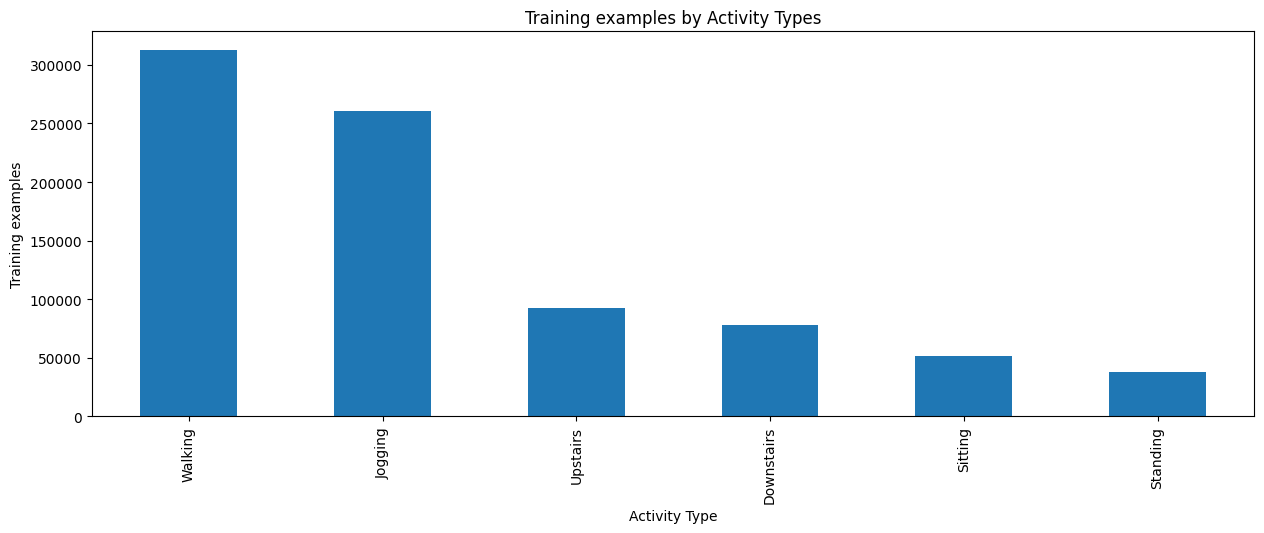

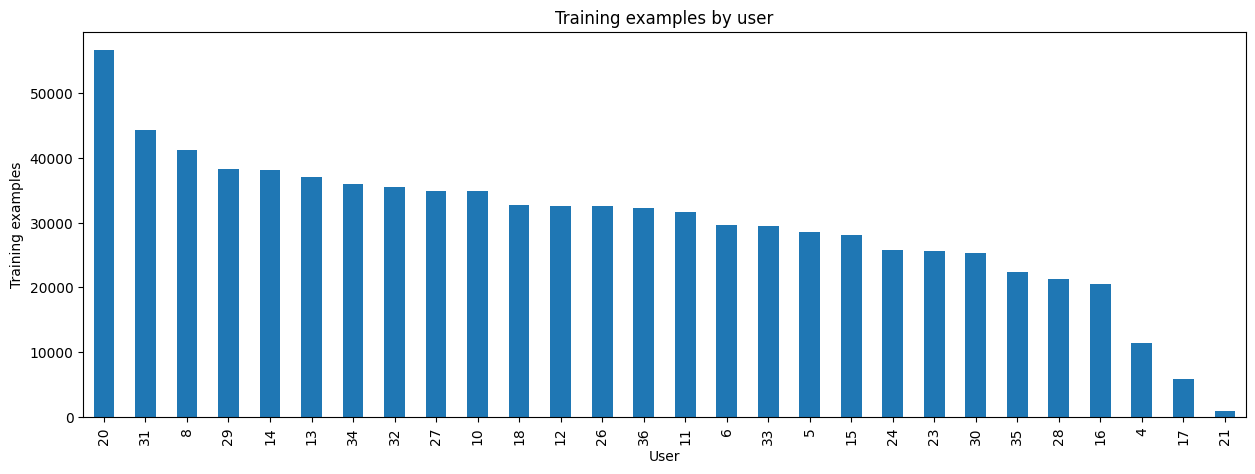

In [6]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

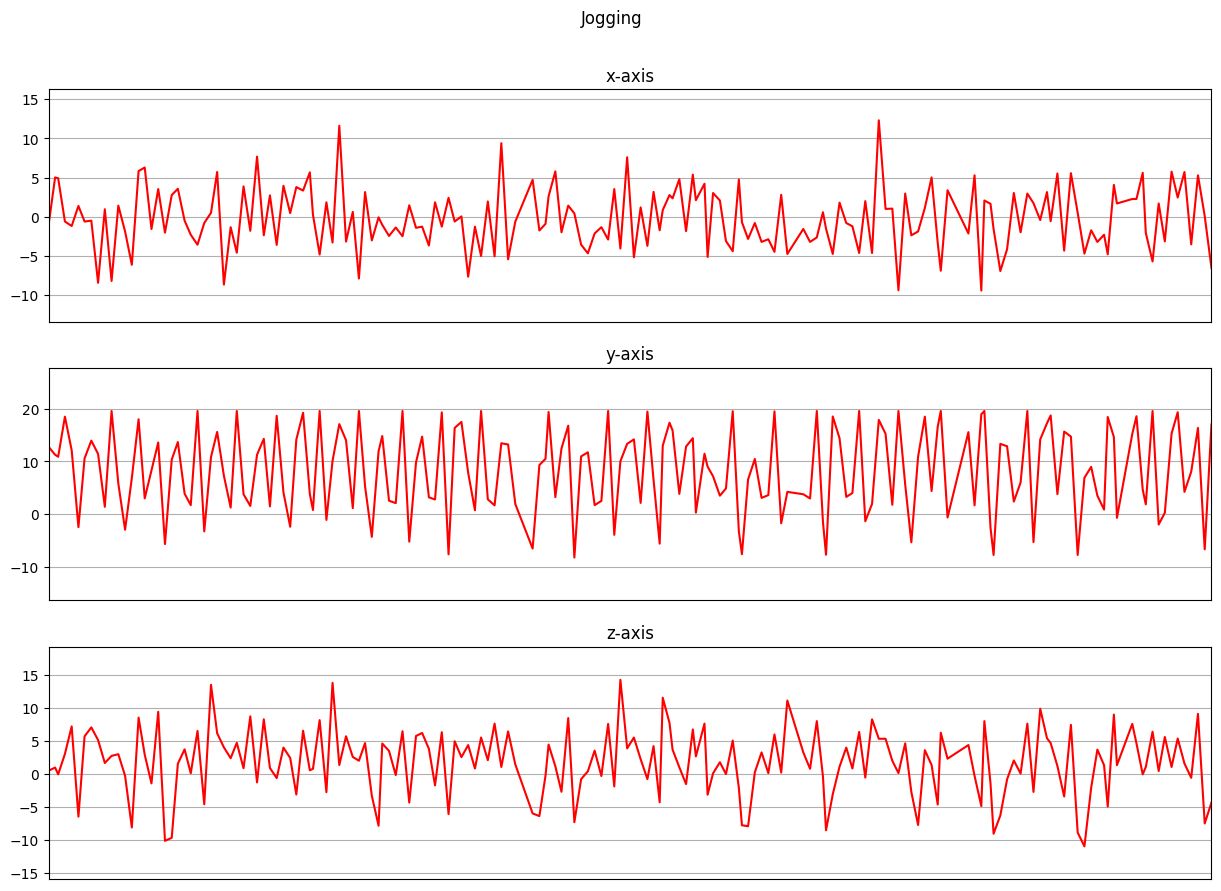

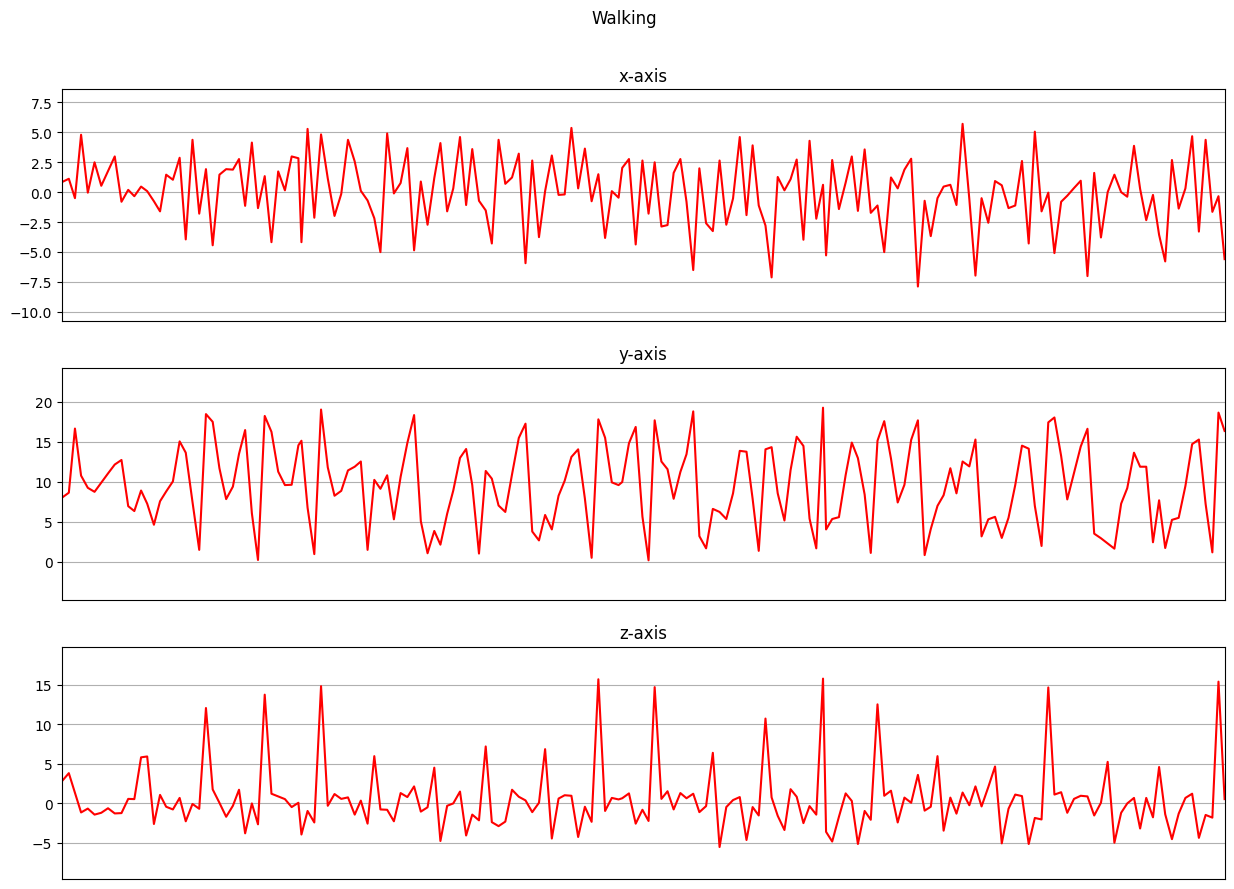

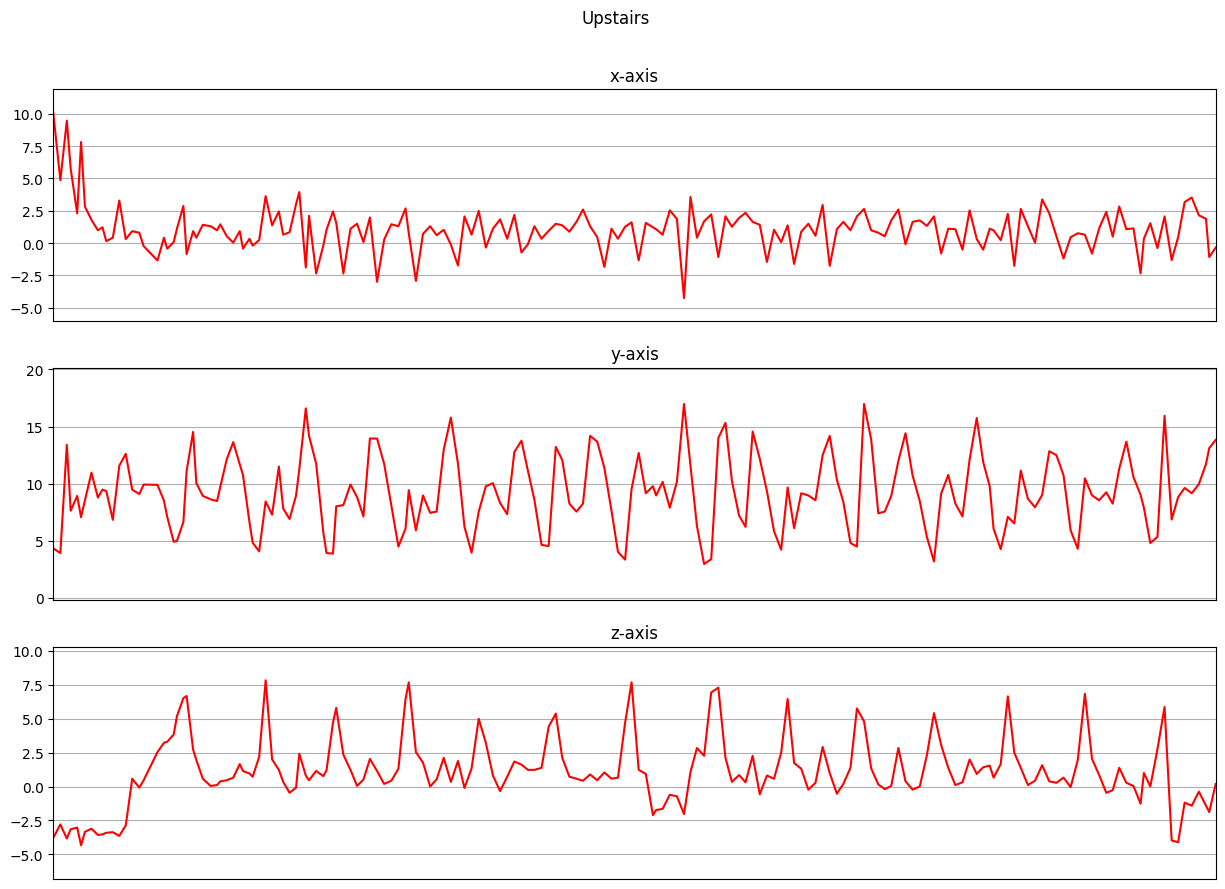

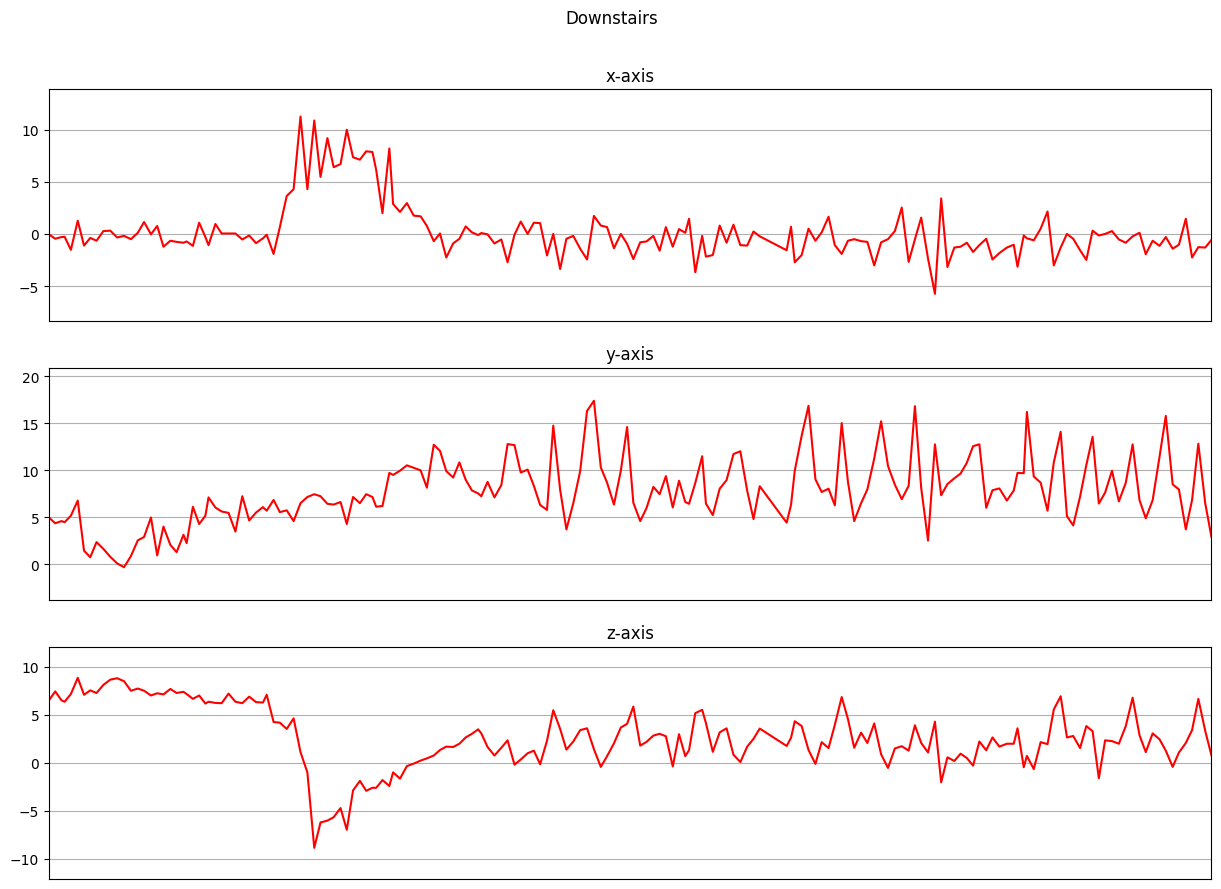

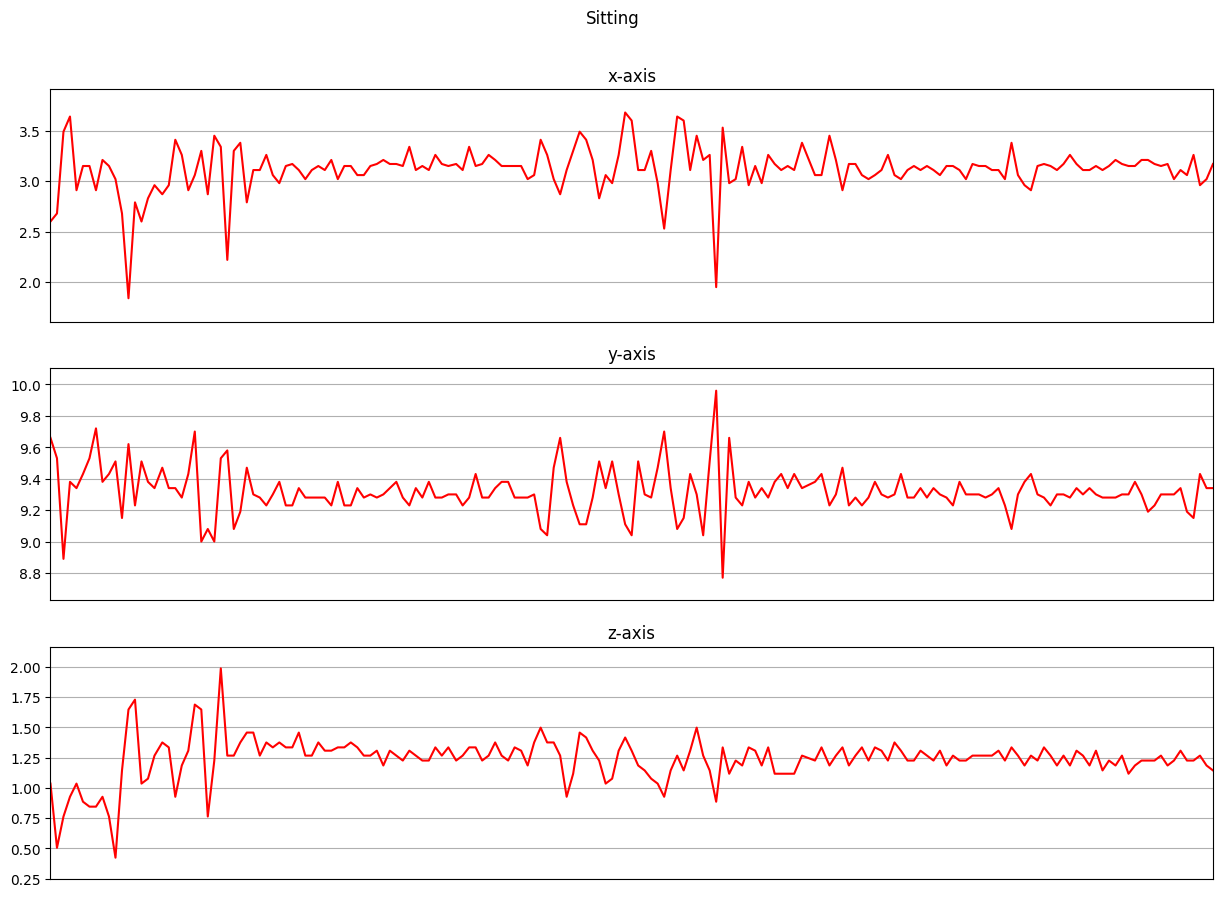

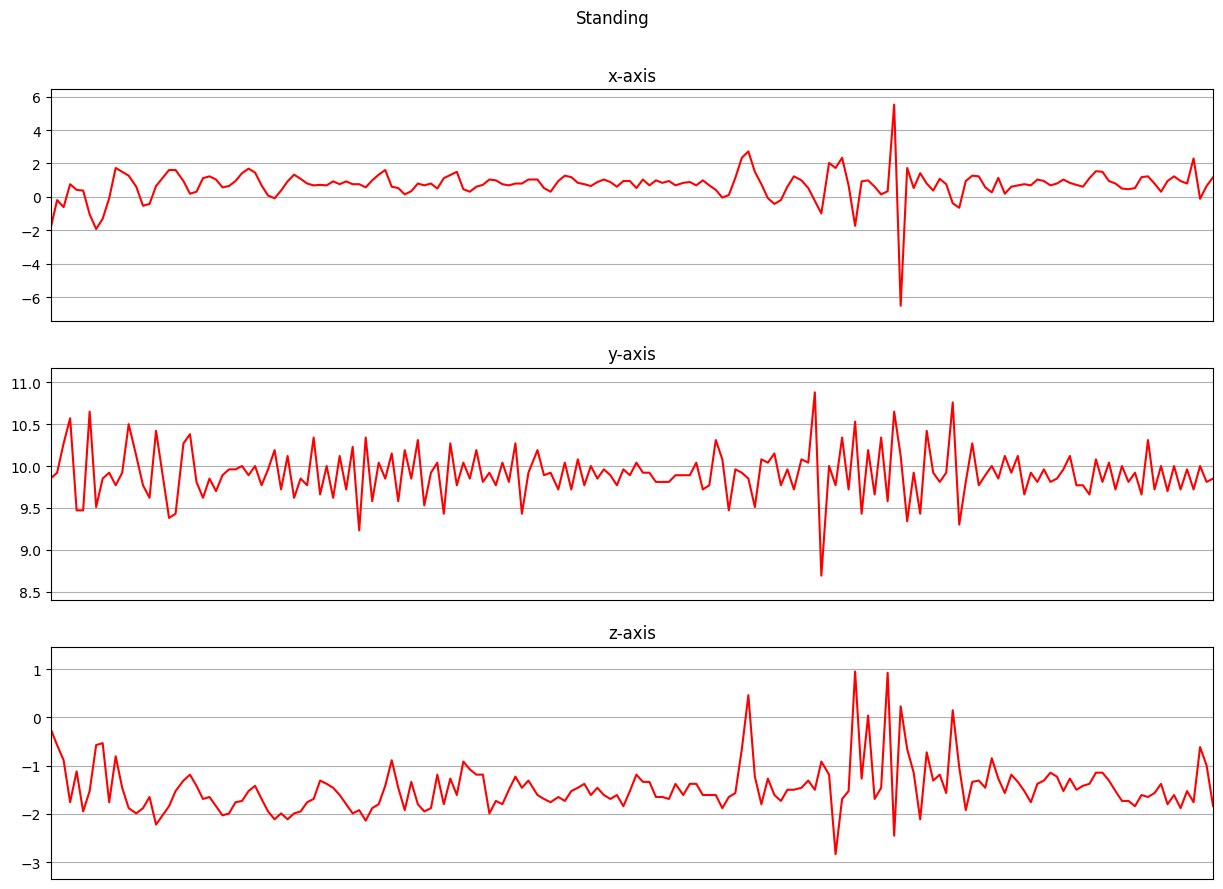

In [7]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

## Data preprocessing

#### Label encoding

In [8]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
833845,21,Walking,117051091559000,-4.710000,15.130000,1.120000,5
833846,21,Walking,117051171515000,2.790000,8.660000,1.080000,5
833847,21,Walking,117051211615000,0.270000,5.560000,1.460000,5
833848,21,Walking,117051251593000,-0.890000,4.290000,1.310000,5


### Linear interpolation
#### Using linear interpolation we can overcome the problem of data that is lost during the collection process which is indicated by NaN. It will fill the missing values.

In [9]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

0.91


## Data split
##### The data is split according to the user IDs to avoid the wrong data split. We are taking users with IDs less than or equal to 27 in our training set and the rest in our test set.

In [10]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

### Normalization
##### Now we will normalize our training data features to the range of 0 to 1. The method that we are using for normalization is 
#### where n denotes the number of channels, and Xi max and Xi min are the maximum and minimum values of the i−th channel, respectively.

In [11]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510680,0.741908,0.487892,5
8490,17,Walking,57870012316000,0.496204,0.751526,0.486853,5
8491,17,Walking,57870122301000,0.490345,0.742938,0.483737,5
8492,17,Walking,57870222246000,0.499996,0.748778,0.488585,5
8493,17,Walking,57870332292000,0.499996,0.750496,0.485815,5
...,...,...,...,...,...,...,...
833845,21,Walking,117051091559000,0.377024,0.876166,0.529875,5
833846,21,Walking,117051171515000,0.566802,0.712989,0.528858,5
833847,21,Walking,117051211615000,0.503036,0.634805,0.538520,5
833848,21,Walking,117051251593000,0.473684,0.602774,0.534706,5


## Segmentation
##### Reshaping of dataframe is needed for it to be fed into our model. For this, we will create a function called segments that will take in the dataframe, the label names, and the length of each record which is set to 80 steps. This function will also perform separation of features (X-acceleration, Y-acceleration, Z-acceleration) and labels in x_train and y_train respectively.

In [12]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [13]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (13725, 80, 3)
Training samples: 13725
y_train shape: (13725,)


In [14]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [15]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (13725, 240)


In [16]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

## One-Hot encoding

In [17]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)


y_train shape:  (13725, 6)


In [18]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 240, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

2023-07-07 09:09:16.652298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 09:09:16.652760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 09:09:16.653114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 240, 32)           8320      
                                                                 
 reshape (Reshape)           (None, 1, 240, 32)        0         
                                                                 
 conv1d (Conv1D)             (None, 1, 120, 64)        4160      
                                                                 
 reshape_1 (Reshape)         (None, 120, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 64)           0         
 )                                                               
                                                        

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train_hot, 
                    batch_size= 192, 
                    epochs=100
                   )

Epoch 1/100


2023-07-07 09:09:23.780424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-07 09:09:25.542355: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-07 09:09:25.773102: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9d90025b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 09:09:25.773133: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-07-07 09:09:25.841487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-07 09:09:26.263594: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-07 09:09:26.357399: I ./tensorflow/compiler/jit/device_comp

72/72 [==============================] - 53s 605ms/step - loss: 1.0136 - accuracy: 0.6648
Epoch 2/100
72/72 [==============================] - 42s 590ms/step - loss: 0.6202 - accuracy: 0.7741
Epoch 3/100
72/72 [==============================] - 43s 590ms/step - loss: 0.4956 - accuracy: 0.8048
Epoch 4/100
72/72 [==============================] - 43s 600ms/step - loss: 0.4541 - accuracy: 0.8273
Epoch 5/100
72/72 [==============================] - 43s 603ms/step - loss: 0.4196 - accuracy: 0.8410
Epoch 6/100
72/72 [==============================] - 44s 618ms/step - loss: 0.3750 - accuracy: 0.8621
Epoch 7/100
72/72 [==============================] - 43s 601ms/step - loss: 0.3465 - accuracy: 0.8739
Epoch 8/100
72/72 [==============================] - 43s 603ms/step - loss: 0.3197 - accuracy: 0.8849
Epoch 9/100
72/72 [==============================] - 43s 602ms/step - loss: 0.3159 - accuracy: 0.8840
Epoch 10/100
72/72 [==============================] - 44s 605ms/step - loss: 0.2866 - accuracy

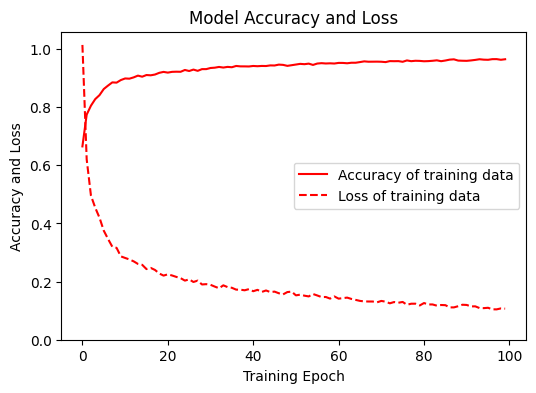

429/429 [==============================] - 25s 58ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1223
         1.0       1.00      0.01      0.03      4531
         2.0       0.00      0.00      0.00       844
         3.0       0.25      1.00      0.40       548
         4.0       0.38      0.00      0.01      1512
         5.0       0.44      1.00      0.61      5067

    accuracy                           0.41     13725
   macro avg       0.35      0.34      0.18     13725
weighted avg       0.55      0.41      0.25     13725



In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [22]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [23]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

223/223 [==============================] - 14s 59ms/step - loss: 5.9886 - accuracy: 0.4453
Accuracy: 0.4453498125076294
Loss: 5.98859977722168


223/223 [==============================] - 13s 56ms/step


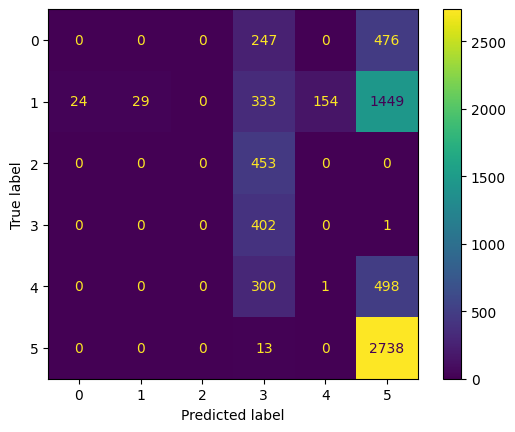

In [24]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [25]:
print(classification_report(y_test_pred, predictions))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       723
           1       1.00      0.01      0.03      1989
           2       0.00      0.00      0.00       453
           3       0.23      1.00      0.37       403
           4       0.01      0.00      0.00       799
           5       0.53      1.00      0.69      2751

    accuracy                           0.45      7118
   macro avg       0.29      0.33      0.18      7118
weighted avg       0.50      0.45      0.30      7118

